In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torchdiffeq import odeint

import sys
sys.path.append('../src')
from mioflow import TimeSeriesDataset, train_mioflow, ODEFunc

<Axes: xlabel='d1', ylabel='d2'>

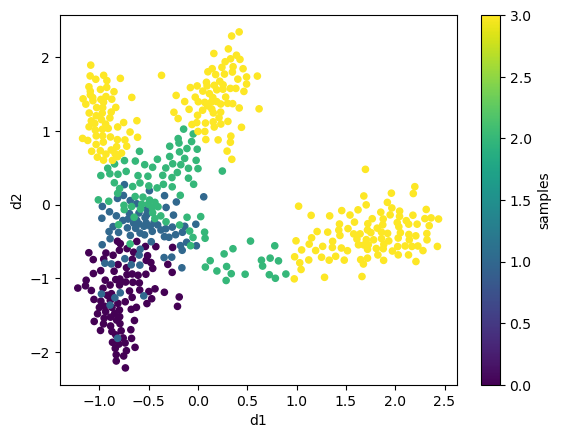

In [ ]:
df_orig = pd.read_csv('../data/trifurcation.csv')
# normalize the data columns whose names start with d
embeddings = df_orig[['d1', 'd2']].values
scaler = StandardScaler().fit(embeddings)
embeddings = scaler.transform(embeddings)
df = pd.DataFrame(embeddings, columns=['d1', 'd2'])
df['samples'] = df_orig['samples']
df.plot.scatter(x='d1', y='d2', c='samples', cmap='viridis')

In [3]:
time_bins = df['samples'].unique()
time_series_data = []
for t in time_bins:
    mask = df['samples'] == t
    points = df[mask][['d1', 'd2']].values
    time_series_data.append((points, float(t)))

mioflow_dataset = TimeSeriesDataset(time_series_data)
mioflow_model = ODEFunc(input_dim=2, hidden_dim=32)

# Train MioFlow
mioflow_history = train_mioflow(
    model=mioflow_model,
    dataset=mioflow_dataset,
    num_epochs=1000,
    mode='local',
    batch_size=512,
    learning_rate=1e-2,
    lambda_ot=1.0,
    lambda_density=0.,
    lambda_energy=0.1,
    energy_time_steps=20,
    scheduler_type='cosine',
    scheduler_min_lr=5e-4,
)

print("MioFlow training completed!")

Epochs: 100%|██████████| 1000/1000 [02:04<00:00,  8.02it/s, Total=0.1065, OT=0.0215, Density=0.0000, Energy=0.8503, LR=5.00e-04]

MioFlow training completed!


MioFlow final losses: {'epoch': 1000.0, 'total_loss': 0.10649378597736359, 'ot_loss': 0.021467308203379314, 'density_loss': 0.0, 'energy_loss': 0.8502647976080576}


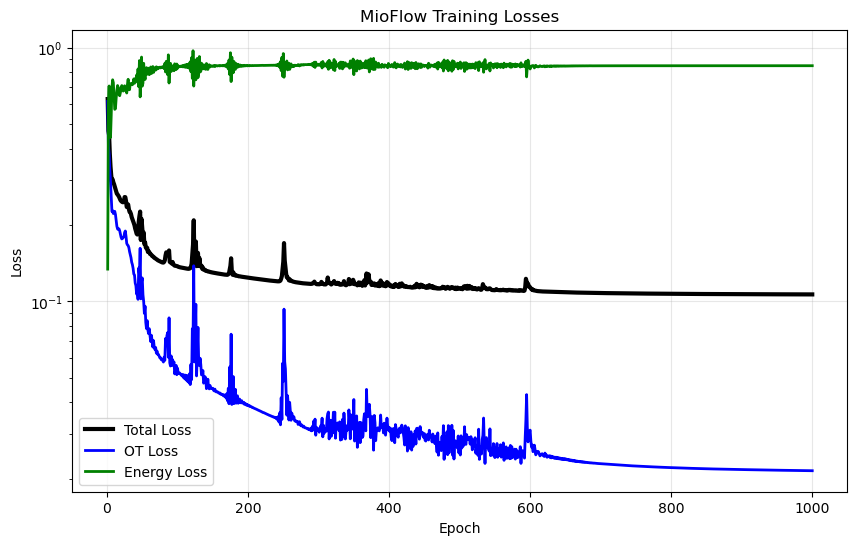

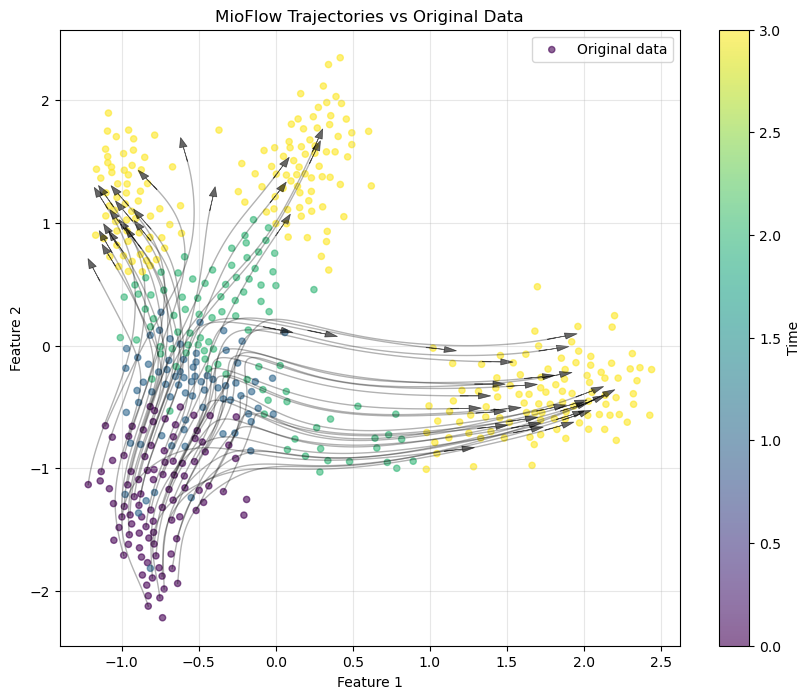

In [4]:
# Robust history processing (handle empty lists)
def get_final_losses(history_dict):
    """Safely extract final losses, handling empty lists and different data types."""
    final_losses = {}
    for k, v in history_dict.items():
        if k != 'learning_rates':
            try:
                # Handle different sequence types (list, numpy array, etc.)
                if hasattr(v, '__len__') and len(v) > 0:
                    final_losses[k] = float(v[-1])  # Convert to float for consistency
            except (IndexError, TypeError, KeyError):
                # Skip if we can't access the last element
                continue
    return final_losses


# Extract and print final losses
final_losses = get_final_losses(mioflow_history)
print("MioFlow final losses:", final_losses)

epochs = mioflow_history['epoch']

plt.figure(figsize=(10, 6))
plt.plot(epochs, mioflow_history['total_loss'], 'k-', linewidth=3, label='Total Loss')
plt.plot(epochs, mioflow_history['ot_loss'], 'b-', linewidth=2, label='OT Loss')
# plt.plot(epochs, mioflow_history['density_loss'], 'r-', linewidth=2, label='Density Loss')
plt.plot(epochs, mioflow_history['energy_loss'], 'g-', linewidth=2, label='Energy Loss')

plt.title('MioFlow Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Optional: log scale for better visualization
plt.show()


# In[118]:


# Get initial condition and subsample points
X_0_full = mioflow_dataset.get_initial_condition()  # [full_size, n_features]
n_pts = 500  # or whatever subsample size you want
indices = torch.randperm(X_0_full.size(0))[:n_pts]
X_0_sample = X_0_full[indices]  # [n_pts, n_features]

# Get time range and create 100 time bins
times = mioflow_dataset.times
t_min, t_max = min(times), max(times)
t_bins = torch.linspace(t_min, t_max, 100)  # [100]

# Integrate trajectories
with torch.no_grad():
    trajectories = odeint(mioflow_model, X_0_sample, t_bins)  # [100, n_pts, n_features]

# Rearrange to [n_pts, 100, n_features] as requested
trajectories = trajectories.permute(1, 0, 2)  # [n_pts, 100, n_features]


# In[119]:


import matplotlib.pyplot as plt
import numpy as np

# Assuming 2D data - if higher dimensional, you might want to project first
# Get all original data points and their times
all_points = []
all_times = []
for i in range(len(mioflow_dataset.time_series_data)):
    points, time = mioflow_dataset.time_series_data[i]
    all_points.append(points)
    all_times.extend([time] * len(points))

all_points = np.vstack(all_points)  # [total_points, n_features]
all_times = np.array(all_times)     # [total_points]

# Create the plot
plt.figure(figsize=(10, 8))

# Plot original data points colored by time
scatter = plt.scatter(all_points[:, 0], all_points[:, 1], 
                     c=all_times, cmap='viridis', alpha=0.6, s=20,
                     label='Original data')

# Plot trajectories as lines and add arrows at the end
for i in range(min(50, trajectories.size(0))):  # Plot first 50 trajectories to avoid clutter
    traj = trajectories[i].cpu().numpy()  # [100, n_features]
    plt.plot(traj[:, 0], traj[:, 1], 'k-', alpha=0.3, linewidth=1)
    # Add an arrow at the end of the trajectory
    if traj.shape[0] >= 2:
        # Arrow from second-to-last to last point
        x_start, y_start = traj[-2, 0], traj[-2, 1]
        x_end, y_end = traj[-1, 0], traj[-1, 1]
        dx, dy = x_end - x_start, y_end - y_start
        # Normalize arrow length for better visibility
        arrow_length = np.sqrt(dx**2 + dy**2)
        if arrow_length > 0:
            scale = 0.2 / arrow_length  # Arrow will be 0.2 units long
            dx_scaled, dy_scaled = dx * scale, dy * scale
            plt.arrow(
                x_start, y_start, dx_scaled, dy_scaled,
                head_width=0.05, head_length=0.08, fc='k', ec='k', alpha=0.6, linewidth=0.5, length_includes_head=True
            )

# Add colorbar
plt.colorbar(scatter, label='Time')

plt.title('MioFlow Trajectories vs Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
